<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/Movie-Recommendation-System-Text-Clasification/blob/main/TM_movie_recomandation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Content-Based Movie Recommendation System**

**Overview**
This project implements a comparative analysis of recommendation algorithms, evolving from statistical methods to State-of-the-Art Deep Learning. The system solves the "cold-start" problem by analyzing movie metadata (Plot, Genres, Keywords) to predict semantic similarity.

**Dataset**: [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) (Subset of 45,000 movies).

**Evolutionary Pipeline**
We evaluate four distinct architectures to maximize **Precision@K**:

1. **Statistical Baseline (LSA):** Reduces noise using SVD (Singular Value Decomposition) on TF-IDF vectors. Good for exact keyword matching (~80% Accuracy).
2. **Deep Learning (SBERT MPNet):** Uses a pre-trained Bi-Encoder Transformer to capture semantic context ("scary"  "terrifying"). (~88% Accuracy).
3. **Hybrid System (Ensemble):** A weighted combination of MPNet (Context) and LSA (Keywords) to balance semantic understanding with specific term matching. (~90% Accuracy).
4. **Re-Ranking (Cross-Encoder):** A two-stage pipeline. Fast retrieval with MPNet followed by a high-precision reranking step using a Cross-Encoder. (~96% Accuracy).

**Visualization**
The project features a **Dual-View Semantic Map** using t-SNE, visualizing the global movie cluster alongside a zoomed-in view of the query's nearest neighbors.

---

#Installing and Importing

In [1]:
!pip install adjustText

In [2]:
import ast
import random
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
import matplotlib.patches as mpatches
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from transformers import logging as hf_logging
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sentence_transformers import CrossEncoder, SentenceTransformer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Cleaning

**NOTE**: Need to be run only once. The clean file is already saved on the drive.

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/datasets/TM/movies/movies_metadata.csv',low_memory=False)
keywords_df = pd.read_csv('/content/drive/MyDrive/datasets/TM/movies/keywords.csv')

print(movies_df.columns)
print(keywords_df.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
Index(['id', 'keywords'], dtype='object')


Drop the unnecessary columns

In [ ]:
movies_df.drop(columns=['popularity','release_date','runtime','original_title','belongs_to_collection','imdb_id','adult','poster_path','homepage','video','budget','revenue','spoken_languages','vote_average','vote_count','production_companies','production_countries','original_language'],inplace=True)

Drop the null values and keep only the movies that are released, in production or post (we want movies that are sure to be released)

In [ ]:
movies_df.dropna(inplace=True,subset=['overview','title','id'])
movies_df.dropna(inplace=True,subset=['overview','id'])
keywords_df.dropna(subset=['id','keywords'],inplace=True)

movies_df = movies_df[movies_df['status'].isin(['Released','In Production','Post Production'])]
movies_df.drop(columns=['status'],inplace=True)

movies_df

,genres,id,overview,tagline,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",NaN,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II
...,...,...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Rising and falling between a man and woman,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,NaN,Century of Birthing
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,"When one of her hits goes wrong, a professiona...",A deadly game of wits.,Betrayal
45464,[],227506,"In a small town live two brothers, one a minis...",NaN,Satan Triumphant


Convert the columns type

In [ ]:
print(movies_df.dtypes)
print()
print(keywords_df.dtypes)

genres      object
id          object
overview    object
tagline     object
title       object
dtype: object

id           int64
keywords    object
dtype: object


In [ ]:
movies_df = movies_df.astype({
                  'id':'int64',
                  'overview':'string',
                  'tagline': 'string',
                  'title': 'string'
                  })

Merge movies with the keywords datasets

In [ ]:
movies = pd.merge(movies_df,keywords_df,how='inner',left_on='id',right_on='id')
movies

,genres,id,overview,tagline,title,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",<NA>,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...
45174,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Rising and falling between a man and woman,Subdue,"[{'id': 10703, 'name': 'tragic love'}]"
45175,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,<NA>,Century of Birthing,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
45176,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,"When one of her hits goes wrong, a professiona...",A deadly game of wits.,Betrayal,[]
45177,[],227506,"In a small town live two brothers, one a minis...",<NA>,Satan Triumphant,[]


Tranform the dictionaries into lists from genres and keywords columns

In [ ]:
def list_from_json(json_str):
  l = []
  # Ensure json_str is a valid string representation of a list or dictionary
  if isinstance(json_str, str) and json_str.strip():
      parsed_list = ast.literal_eval(json_str)
      for i in parsed_list:
        if isinstance(i, dict) and 'name' in i:
            l.append(i['name'])
  elif isinstance(json_str, list):
      for i in json_str:
          if isinstance(i, dict) and 'name' in i:
              l.append(i['name'])
  return l

movies['genres'] = movies['genres'].apply(list_from_json)
movies['keywords'] = movies['keywords'].apply(list_from_json)
movies.drop('id',axis=1,inplace=True)
movies

,genres,overview,tagline,title,keywords
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",,Toy Story,"[jealousy, toy, boy, friendship, friends, riva..."
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,"[board game, disappearance, based on children'..."
2,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[fishing, best friend, duringcreditsstinger, o..."
3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,Waiting to Exhale,"[based on novel, interracial relationship, sin..."
4,[Comedy],Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...,...
45174,"[Drama, Family]",Rising and falling between a man and woman.,Rising and falling between a man and woman,Subdue,[tragic love]
45175,[Drama],An artist struggles to finish his work while a...,,Century of Birthing,"[artist, play, pinoy]"
45176,"[Action, Drama, Thriller]","When one of her hits goes wrong, a professiona...",A deadly game of wits.,Betrayal,
45177,,"In a small town live two brothers, one a minis...",,Satan Triumphant,


Save the new dataset for future used.

In [ ]:
movies.to_csv('/content/drive/MyDrive/datasets/TM/movies_clean.csv',index=False)

#Tranform dataset

In [4]:
# Upload data
df = pd.read_csv('/content/drive/MyDrive/datasets/TM/movies_clean.csv', low_memory=False)

# Cleaning
df['genres'] = df['genres'].astype(str).apply(lambda x: ast.literal_eval(x) if x.startswith('[') and x.endswith(']') else [])
df['keywords'] = df['keywords'].astype(str).apply(lambda x: ast.literal_eval(x) if x.startswith('[') and x.endswith(']') else [])

# Create the document for analysis
df['tagline'] = df['tagline'].fillna('')
df['keywords_str'] = df['keywords'].apply(lambda x: ' '.join(x))
df['full_text'] = df['title'] + " " + df['tagline'] + " " + df['overview']+ " " + df['keywords_str']
display(df['full_text'].head(10))

# Encode the tags
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])
print(f"Exemple of y value: {y[0]}")
print(f"For genders {df['genres'].iloc[0]}")

,full_text
0,"Toy Story Led by Woody, Andy's toys live happ..."
1,Jumanji Roll the dice and unleash the exciteme...
2,Grumpier Old Men Still Yelling. Still Fighting...
3,Waiting to Exhale Friends are the people who l...
4,Father of the Bride Part II Just When His Worl...
5,Heat A Los Angeles Crime Saga Obsessive master...
6,Sabrina You are cordially invited to the most ...
7,Tom and Huck The Original Bad Boys. A mischiev...
8,Sudden Death Terror goes into overtime. Intern...
9,GoldenEye No limits. No fears. No substitutes....


Exemple of y value: [0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
For genders ['Animation', 'Comedy', 'Family']


#Preparing the Sample for Viewing

In [5]:
# Define the "target" genres for clear visualization
target_genres = ['Fantasy', 'Horror', 'Animation']

# Function for labeling
def get_viz_label(genre_list):
  for g in genre_list:
    if g in target_genres:
      return g
  return None

df['viz_genre'] = df['genres'].apply(get_viz_label)

# Create the working sample (df_viz)
df_viz = df.dropna(subset=['viz_genre']).copy()
df_viz = df_viz.sample(n=min(2000, len(df_viz)), random_state=42)

# Reset the index to align the matrix with the dataframe
df_viz = df_viz.reset_index(drop=True)
print(f"Sample created: {len(df_viz)} movies.")

Sample created: 2000 movies.


In [6]:
# Vectorization
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df_viz['full_text'])

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded = tsne.fit_transform(X_tfidf.toarray())

# Add the results to the DataFrame
df_viz['x'] = X_embedded[:, 0]
df_viz['y'] = X_embedded[:, 1]

cosine_sim_stats = cosine_similarity(X_tfidf, X_tfidf)

#Evalutuate Precision@K

In [7]:
def evaluate_precision_at_k(df, sim_matrix, k=10, n_samples=50, ce_model=None, top_k_candidates=50):
    """
    Calculates the average Precision at K based on genre matching.

    Parameters:
      - sim_matrix: Similarity matrix
      - df_data: DataFrame containing the 'genres' column
      - k: How many recommendations to check
      - n_samples: How many movies to test
      - ce_model: type of the model

    Return:
    - Average Precision at k
    """
    scores = []

    # Choose n random movies for testing
    test_indices = random.sample(list(df.index), min(n_samples, len(df)))

    show_progress = (ce_model is not None)

    for i, idx in enumerate(test_indices):
        if show_progress and i % 10 == 0:
            print(f"Processed: {i}/{len(test_indices)}")

        source_row = df.loc[idx]
        source_genres = set(source_row['genres'])
        if not source_genres: continue

        # The scores from matrix
        matrix_idx = df.index.get_loc(idx)
        sim_scores = list(enumerate(sim_matrix[matrix_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        if ce_model is None:
            # Take the first K from matrix
            final_indices = [x[0] for x in sim_scores[1:k+1]]

        else:
            # Take top 50
            candidate_indices = [x[0] for x in sim_scores[1:top_k_candidates+1]]
            candidate_movies = df.iloc[candidate_indices]

            # Cross-Encoder Predict
            query_text = source_row['sbert_text']
            model_inputs = [[query_text, row['sbert_text']] for _, row in candidate_movies.iterrows()]
            cross_scores = ce_model.predict(model_inputs)

            # Sort
            reranked = sorted(list(zip(candidate_indices, cross_scores)), key=lambda x: x[1], reverse=True)
            final_indices = [x[0] for x in reranked[:k]]

        # Scoring
        relevant_hits = 0
        for rec_idx in final_indices:
            rec_genres = set(df.loc[rec_idx, 'genres'])
            if source_genres.intersection(rec_genres):
                relevant_hits += 1

        scores.append(relevant_hits / k)

    return np.mean(scores)

#Recommender Map

In [8]:
def analyze_movie_similarity_dual(movie_title, df, sim_matrix, x_col, y_col, model_name, custom_indices=None):
    '''
    Create the map for movie similarity from matrix or custom indices.

    Parameters:
      - movie_title: Name of the movie to test
      - df: DataFrame containing the 'genres' column
      - sim_matrix: Similarity matrix
      - x_col: Column name for the x-axis
      - y_col: Column name for the y-axis
      - model_name: Name of the model
      - custom_indices: List of custom indices
    '''
    # Find the movie and recommendations
    matches = df[df['title'].str.lower() == movie_title.lower()]
    if matches.empty:
        print(f"Movie '{movie_title}' not found.")
        return
    query_idx = matches.index[0]
    source_movie = df.loc[query_idx]

    if custom_indices is not None:
        # We have top 10
        recom_movies = df.loc[custom_indices]
    else:
        # Calcultate from matrix
        matrix_idx = df.index.get_loc(query_idx)
        sim_scores = list(enumerate(sim_matrix[matrix_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_indices = [i[0] for i in sim_scores[1:11]]
        recom_movies = df.iloc[top_indices]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

    # GRAPHIC 1: GLOBAL
    ax1.scatter(df[x_col], df[y_col], c='lightgrey', alpha=0.3, s=10) # all movies
    ax1.scatter(recom_movies[x_col], recom_movies[y_col], c='blue', s=50) # the recomandation
    ax1.scatter(source_movie[x_col], source_movie[y_col], c='red', s=80, marker='X') # the target
    ax1.set_title(f"Global View: {len(df)} Movies", fontsize=14)
    ax1.axis('off')

    # GRAPHIC 2: ZOOM
    # Max and min on axes
    all_x = list(recom_movies[x_col]) + [source_movie[x_col]]
    all_y = list(recom_movies[y_col]) + [source_movie[y_col]]

    # Calculate the margin of the grafic
    margin_x = (max(all_x) - min(all_x)) * 0.5 + 2
    margin_y = (max(all_y) - min(all_y)) * 0.5 + 2

    ax2.set_xlim(min(all_x) - margin_x, max(all_x) + margin_x)
    ax2.set_ylim(min(all_y) - margin_y, max(all_y) + margin_y)

    # Add the dots
    ax2.scatter(recom_movies[x_col], recom_movies[y_col], c='blue', s=200, edgecolors='white', linewidth=2)
    ax2.scatter(source_movie[x_col], source_movie[y_col], c='red', s=300, edgecolors='black', marker='X')

    texts = [ax2.text(source_movie[x_col], source_movie[y_col], "SOURCE", fontweight='bold', color='darkred')]
    legend_labels = []

    for i, (idx, row) in enumerate(recom_movies.iterrows(), 1):
        texts.append(ax2.text(row[x_col], row[y_col], str(i), fontsize=12, fontweight='bold'))
        legend_labels.append(f"{i}. {row['title']} ({row['viz_genre']})")

    adjust_text(texts, ax=ax2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    recom_patches = [mpatches.Patch(color='blue', label=label) for label in legend_labels]
    ax2.legend(handles=recom_patches, title='Top 10 Recommendations', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Analysis: '{source_movie['title']}'\nModel: {model_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

#Content-Based Statistics (TD-IDF)

##1. TF-IDF Basic

Average Accuracy (TF-IDF Basic): 81.00%


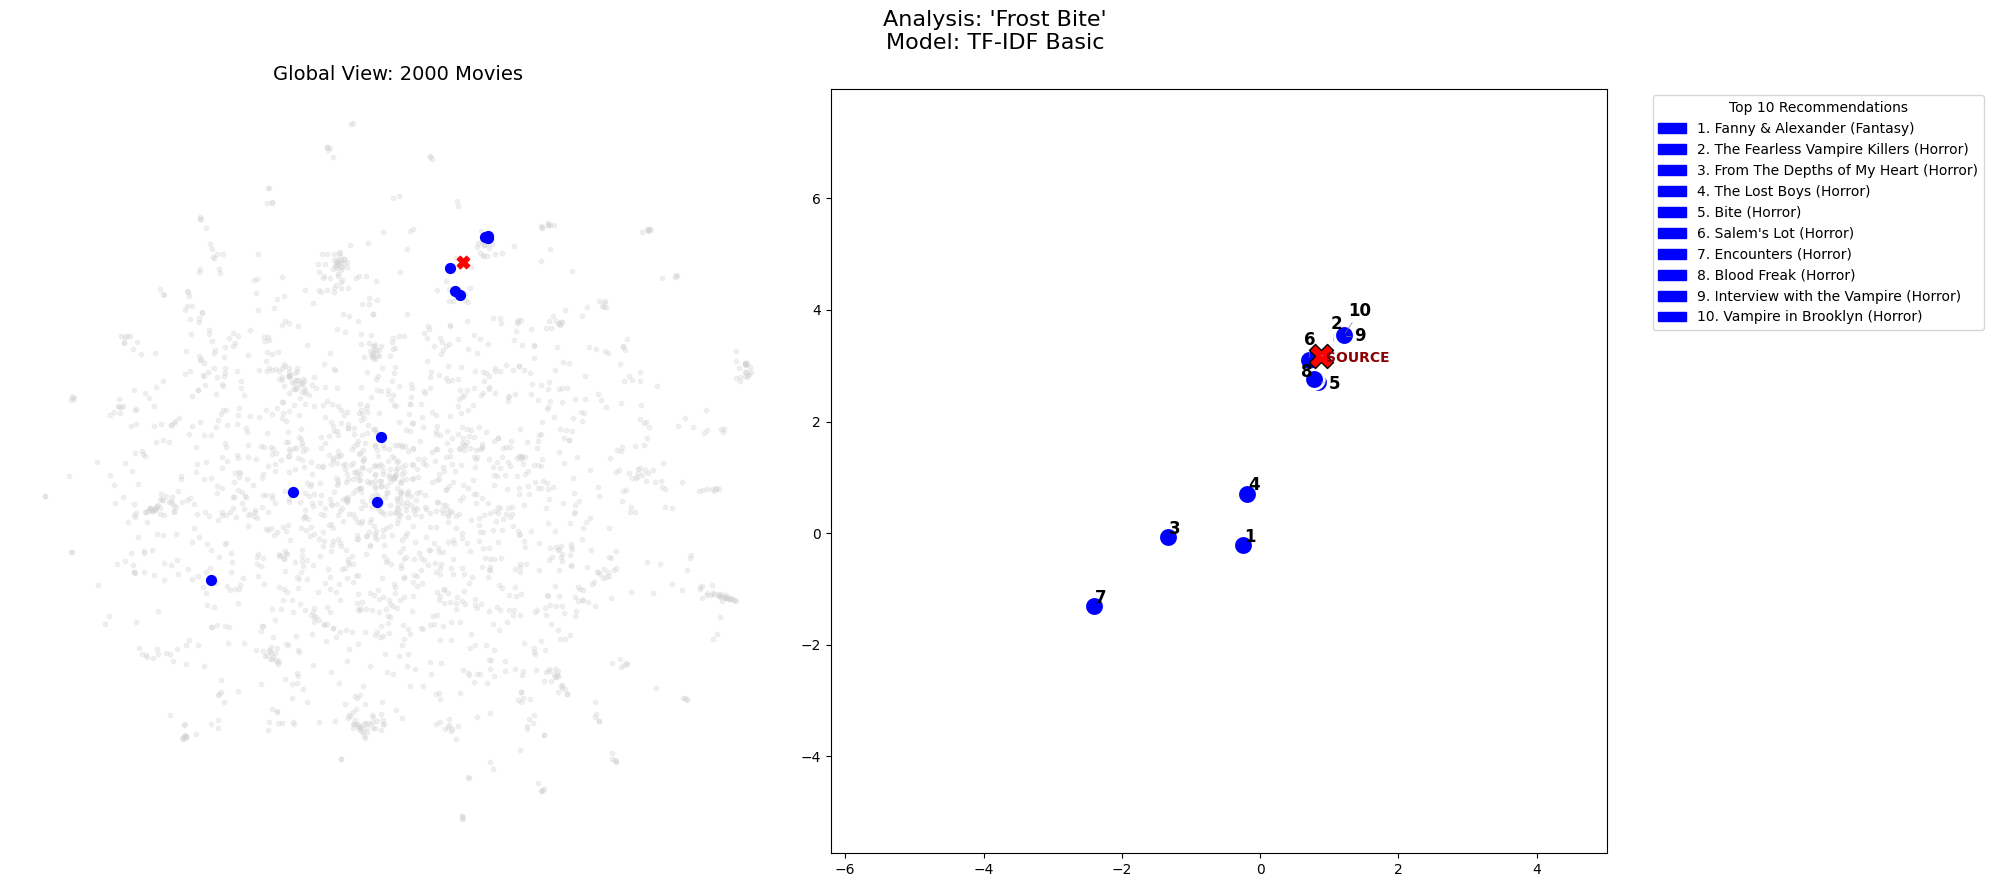

In [11]:
# TF-IDF vectorization
# Take the most frequent 2000 words
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

X_tfidf = tfidf.fit_transform(df_viz['full_text'])

# Similarity Matrix Calculation (Cosine). Calculate the distance between all the movies
cosine_sim_stats = cosine_similarity(X_tfidf, X_tfidf);

# Dimensionality reduction with t-SNE
# Transform vectors from 2000 dimensions to 2 dimensions (x, y)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded = tsne.fit_transform(X_tfidf.toarray())

df_viz['x'] = X_embedded[:, 0]
df_viz['y'] = X_embedded[:, 1]

# Evaluation
score = evaluate_precision_at_k(df_viz, cosine_sim_stats)
print(f"Average Accuracy (TF-IDF Basic): {score:.2%}")

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_stats,
    x_col='x',
    y_col='y',
    model_name="TF-IDF Basic"
)

##2. TF-IDF with N-grams + Boosting



Average Accuracy (TF-IDF Tuned): 76.40%


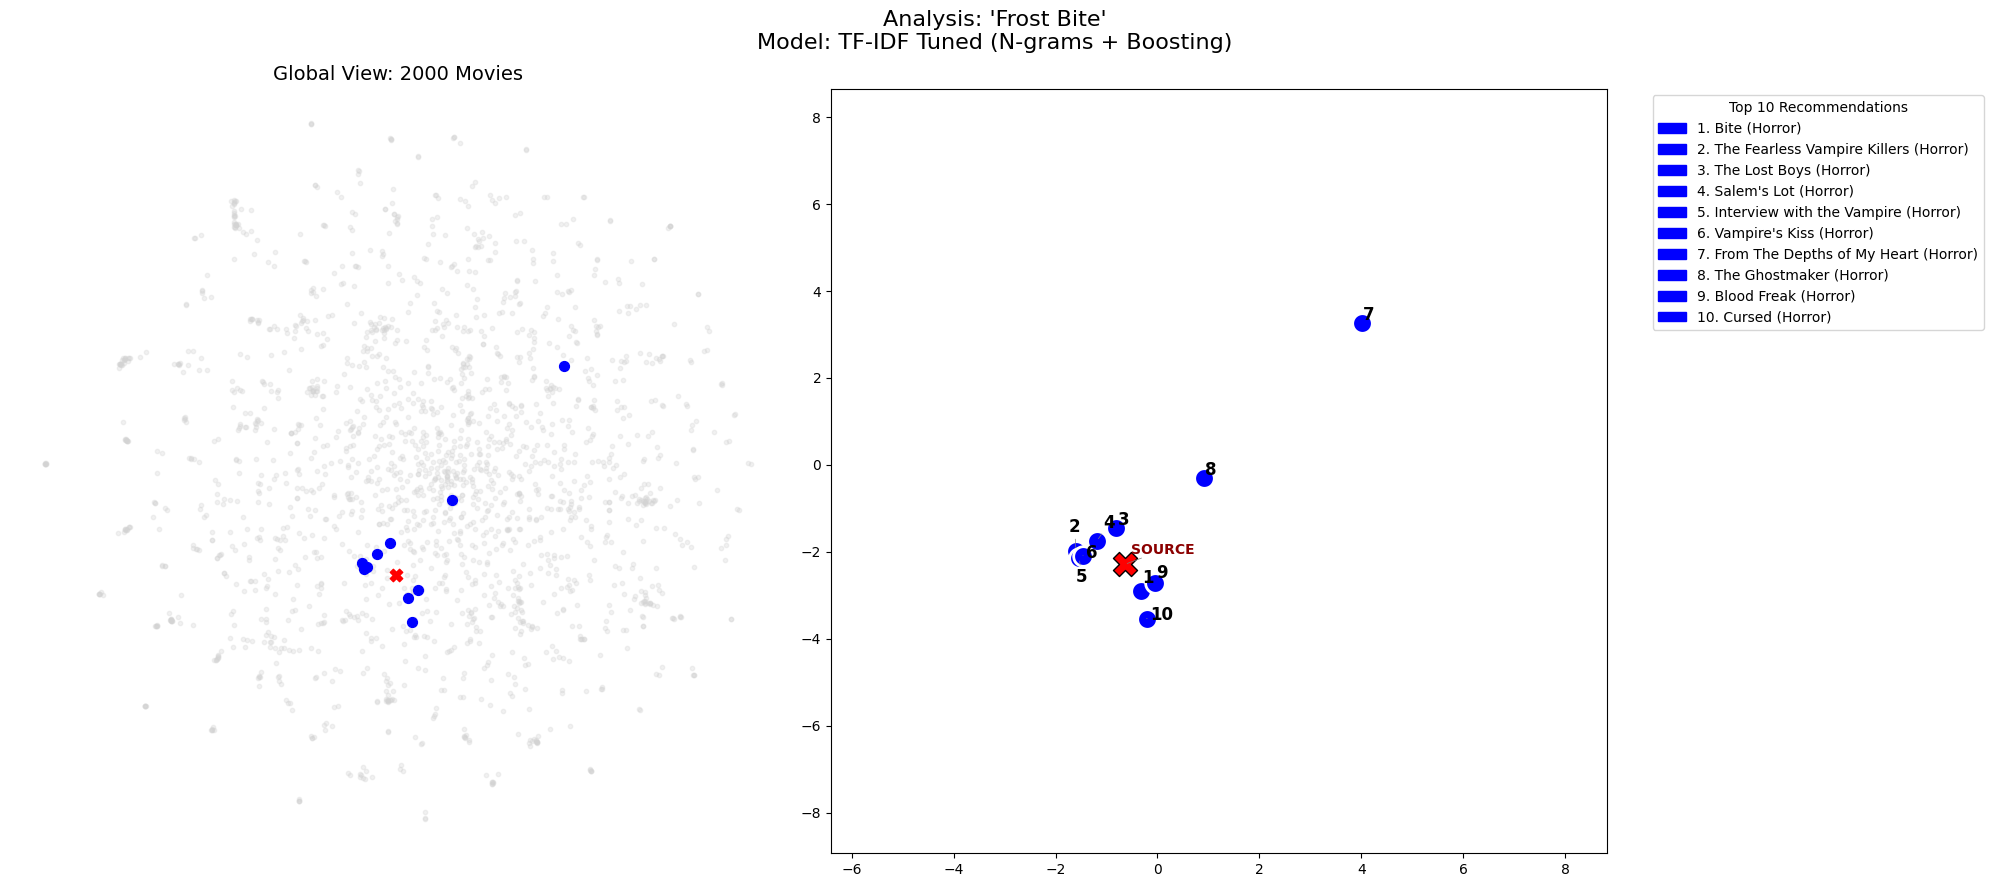

In [13]:
# We remove generic words that confuse us
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(
    ["movie", "film", "cinema", "story", "plot", "character", "series", "production", "director", "written"]
))

# Boosting - we give more importance to the title and keywords
df_viz['full_text_tuned'] = (
    (df_viz['title'] + " ") * 3 +
    (df_viz['keywords_str'] + " ") * 2 +
    df_viz['tagline'] + " " +
    df_viz['overview']
)

# Vectorization
tfidf_tuned = TfidfVectorizer(
  max_features=3000,
  stop_words=my_stop_words,
  ngram_range=(1, 2),
  min_df=3
)

X_tfidf_tuned = tfidf_tuned.fit_transform(df_viz['full_text_tuned'])

# Calculate similarity and TSNE
cosine_sim_tuned = cosine_similarity(X_tfidf_tuned, X_tfidf_tuned)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded_tuned = tsne.fit_transform(X_tfidf_tuned.toarray())

# Save in new columns
df_viz['x_tuned'] = X_embedded_tuned[:, 0]
df_viz['y_tuned'] = X_embedded_tuned[:, 1]

score_tuned = evaluate_precision_at_k(df_viz, cosine_sim_tuned)
print(f"Average Accuracy (TF-IDF Tuned): {score_tuned:.2%}")

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_tuned,
    x_col='x_tuned',
    y_col='y_tuned',
    model_name="TF-IDF Tuned (N-grams + Boosting)"
)

##3. LSA

Average Accuracy (LSA): 85.80%


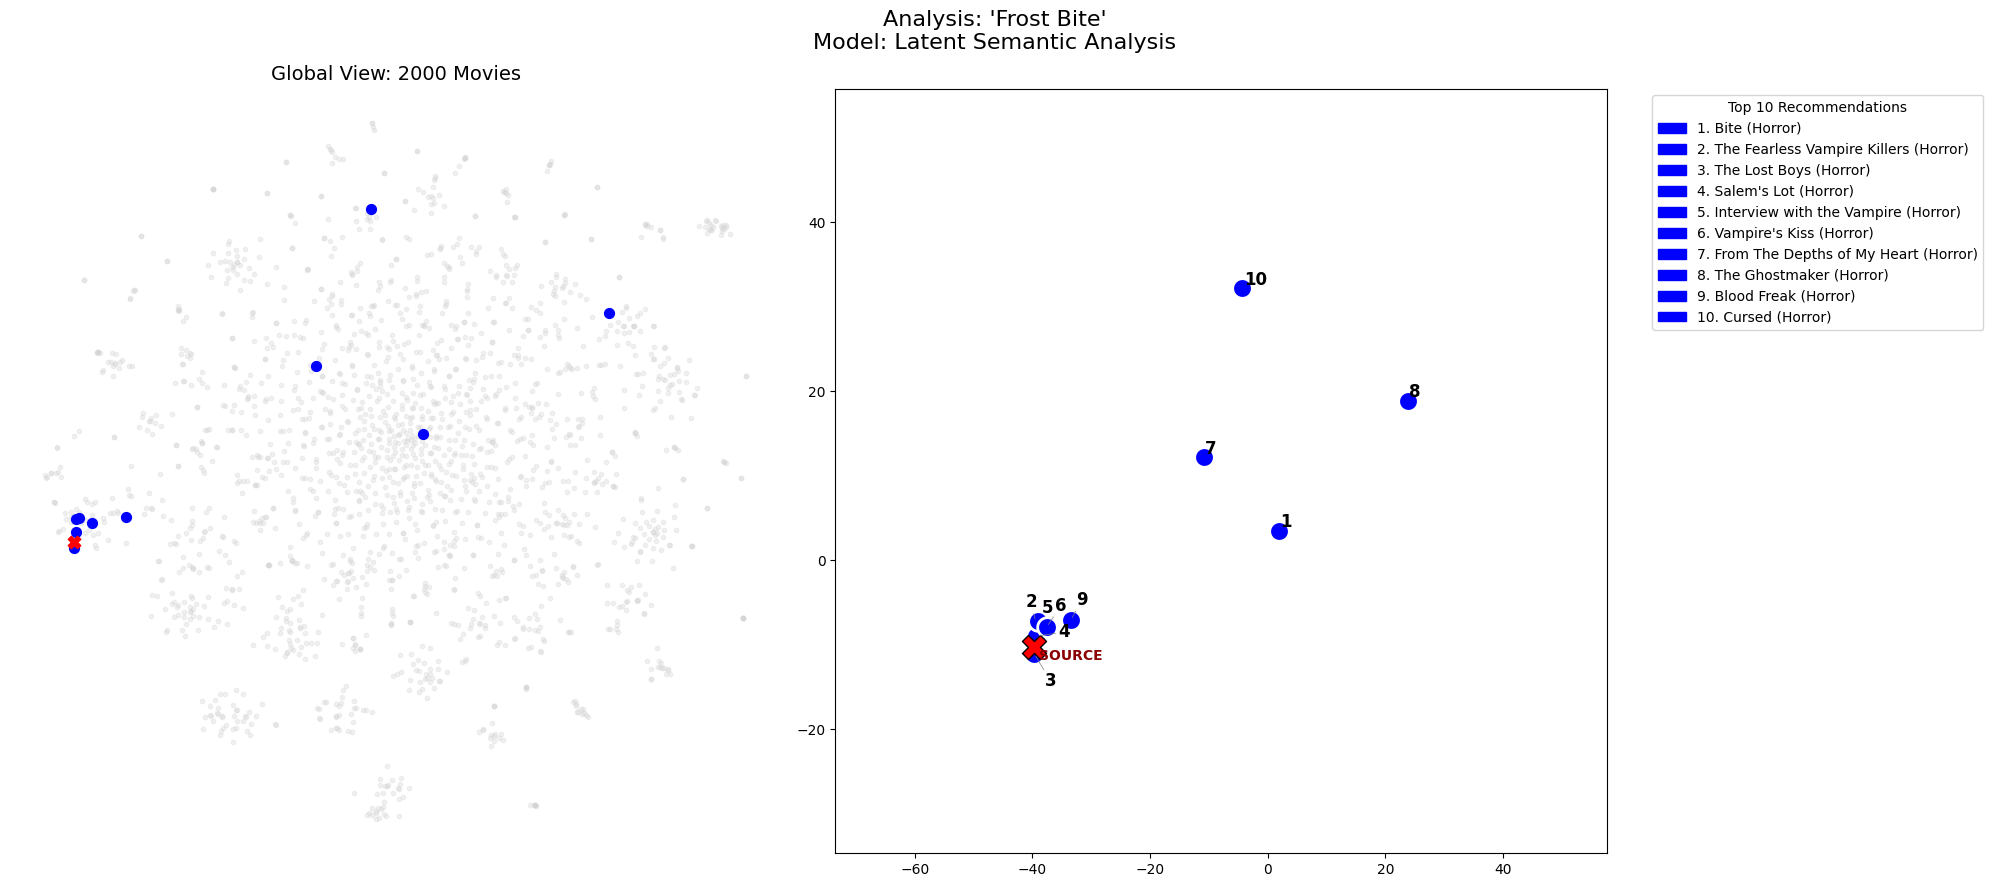

In [14]:
# We keep the boosting on the title, but remove the n-grams
df_viz['full_text_optimized'] = (
    (df_viz['title'] + " ") * 3 +
    (df_viz['keywords_str'] + " ") * 2 +
    df_viz['tagline'] + " " +
    df_viz['overview']
)

tfidf_lsa = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 1),
    sublinear_tf=True
)

X_tfidf_base = tfidf_lsa.fit_transform(df_viz['full_text_optimized'])

# LSA (Latent Semantic Analysis) - compress 5000 words into 100 "concepts"
svd = TruncatedSVD(n_components=100, random_state=42)
X_lsa = svd.fit_transform(X_tfidf_base);

cosine_sim_lsa = cosine_similarity(X_lsa, X_lsa);

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded_lsa = tsne.fit_transform(X_lsa);

df_viz['x_lsa'] = X_embedded_lsa[:, 0]
df_viz['y_lsa'] = X_embedded_lsa[:, 1]

score_lsa = evaluate_precision_at_k(df_viz, cosine_sim_lsa)
print(f"Average Accuracy (LSA): {score_lsa:.2%}")

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_tuned,
    x_col='x_lsa',
    y_col='y_lsa',
    model_name="Latent Semantic Analysis"
)

##4. LSA with grid paramertes

In [15]:
possible_components = [50, 100, 150, 200, 250, 300]
best_score = 0
best_n = 0
results = []

for n in possible_components:
    # Apply SVD with n components
    svd_test = TruncatedSVD(n_components=n, random_state=42)
    # Use the extended vectorization from the previous step
    X_lsa_test = svd_test.fit_transform(X_tfidf_base)

    # Calculate the similarity
    sim_matrix_test = cosine_similarity(X_lsa_test, X_lsa_test)

    # Evaluate the score
    score = evaluate_precision_at_k(df_viz, sim_matrix_test)
    results.append(score)

    print(f"With n={n} components: Accuracy = {score:.2%}")

    if score > best_score:
        best_score = score
        best_n = n

print(f"\nBEST RESULT: {best_score:.2%} with {best_n} components.")

With n=50 components: Accuracy = 83.80%
With n=100 components: Accuracy = 78.40%
With n=150 components: Accuracy = 80.40%
With n=200 components: Accuracy = 77.20%
With n=250 components: Accuracy = 77.80%
With n=300 components: Accuracy = 79.80%

BEST RESULT: 83.80% with 50 components.


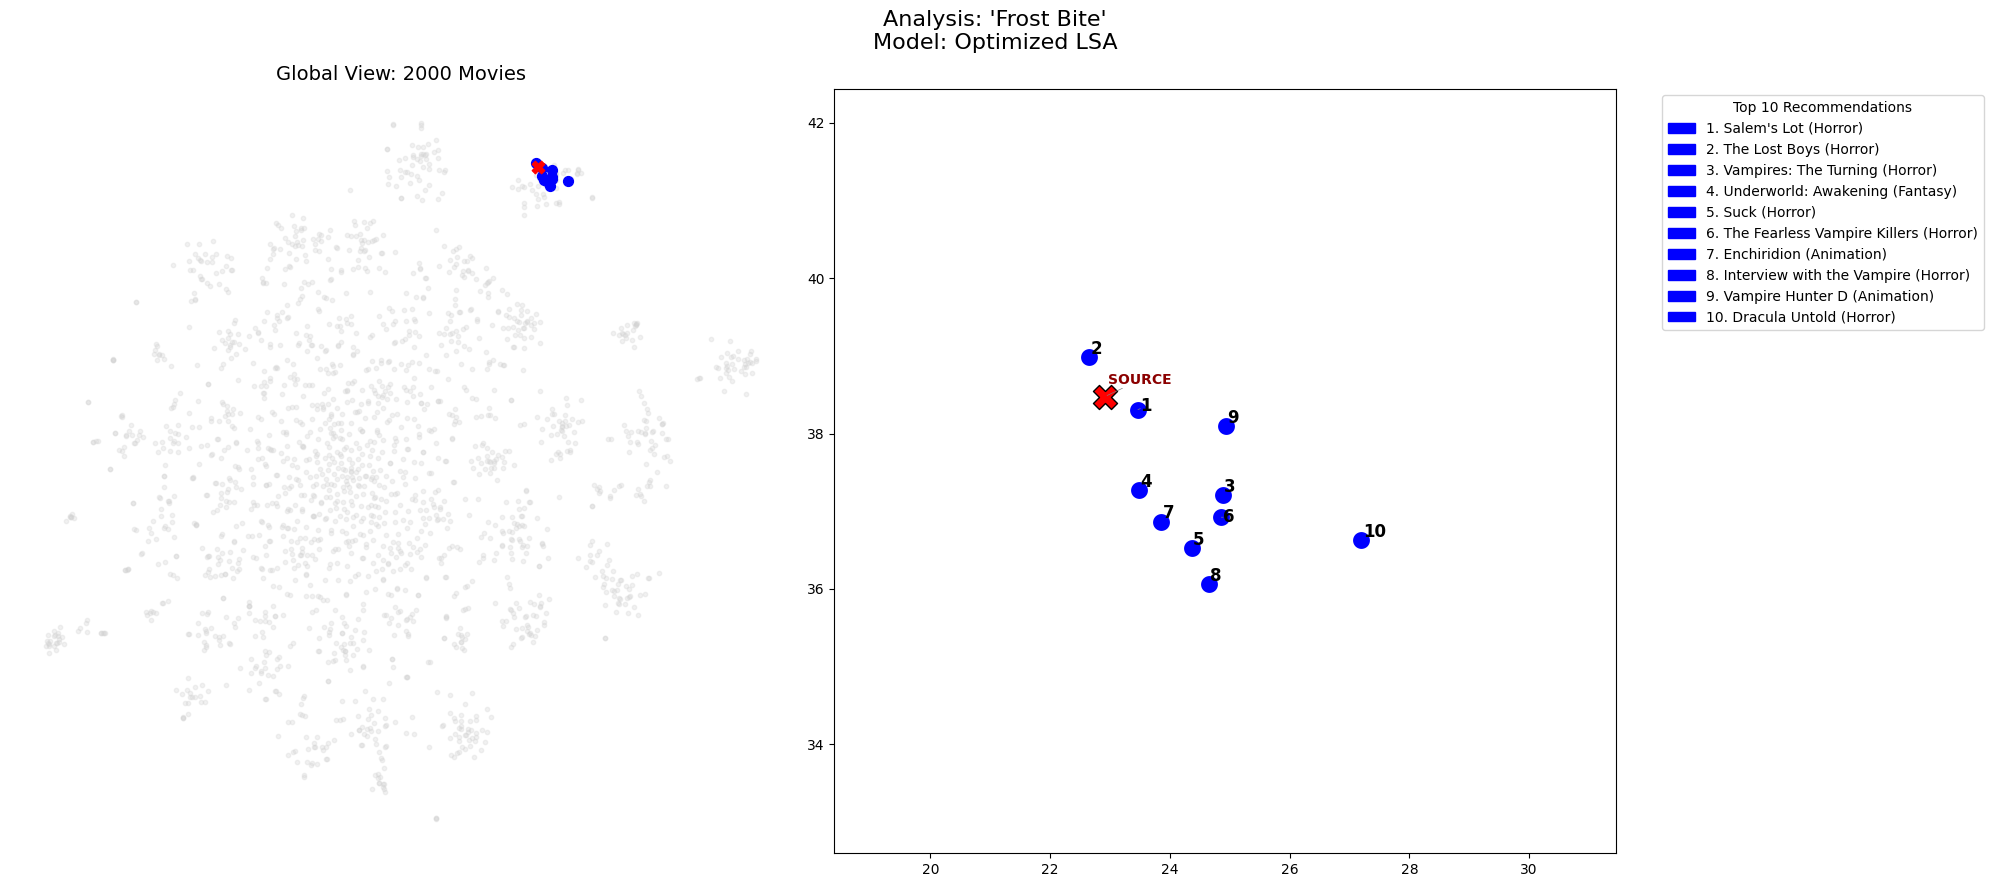

In [16]:
svd_best = TruncatedSVD(n_components=best_n, random_state=42)
X_lsa_best = svd_best.fit_transform(X_tfidf_base)

cosine_sim_best = cosine_similarity(X_lsa_best, X_lsa_best)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded_best = tsne.fit_transform(X_lsa_best)

df_viz['x_best'] = X_embedded_best[:, 0]
df_viz['y_best'] = X_embedded_best[:, 1]

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_best,
    x_col='x_best',
    y_col='y_best',
    model_name="Optimized LSA"
)

#Deep Learning

##1. SBERT with MiniLM

Average Accuracy (SBERT): 79.20%


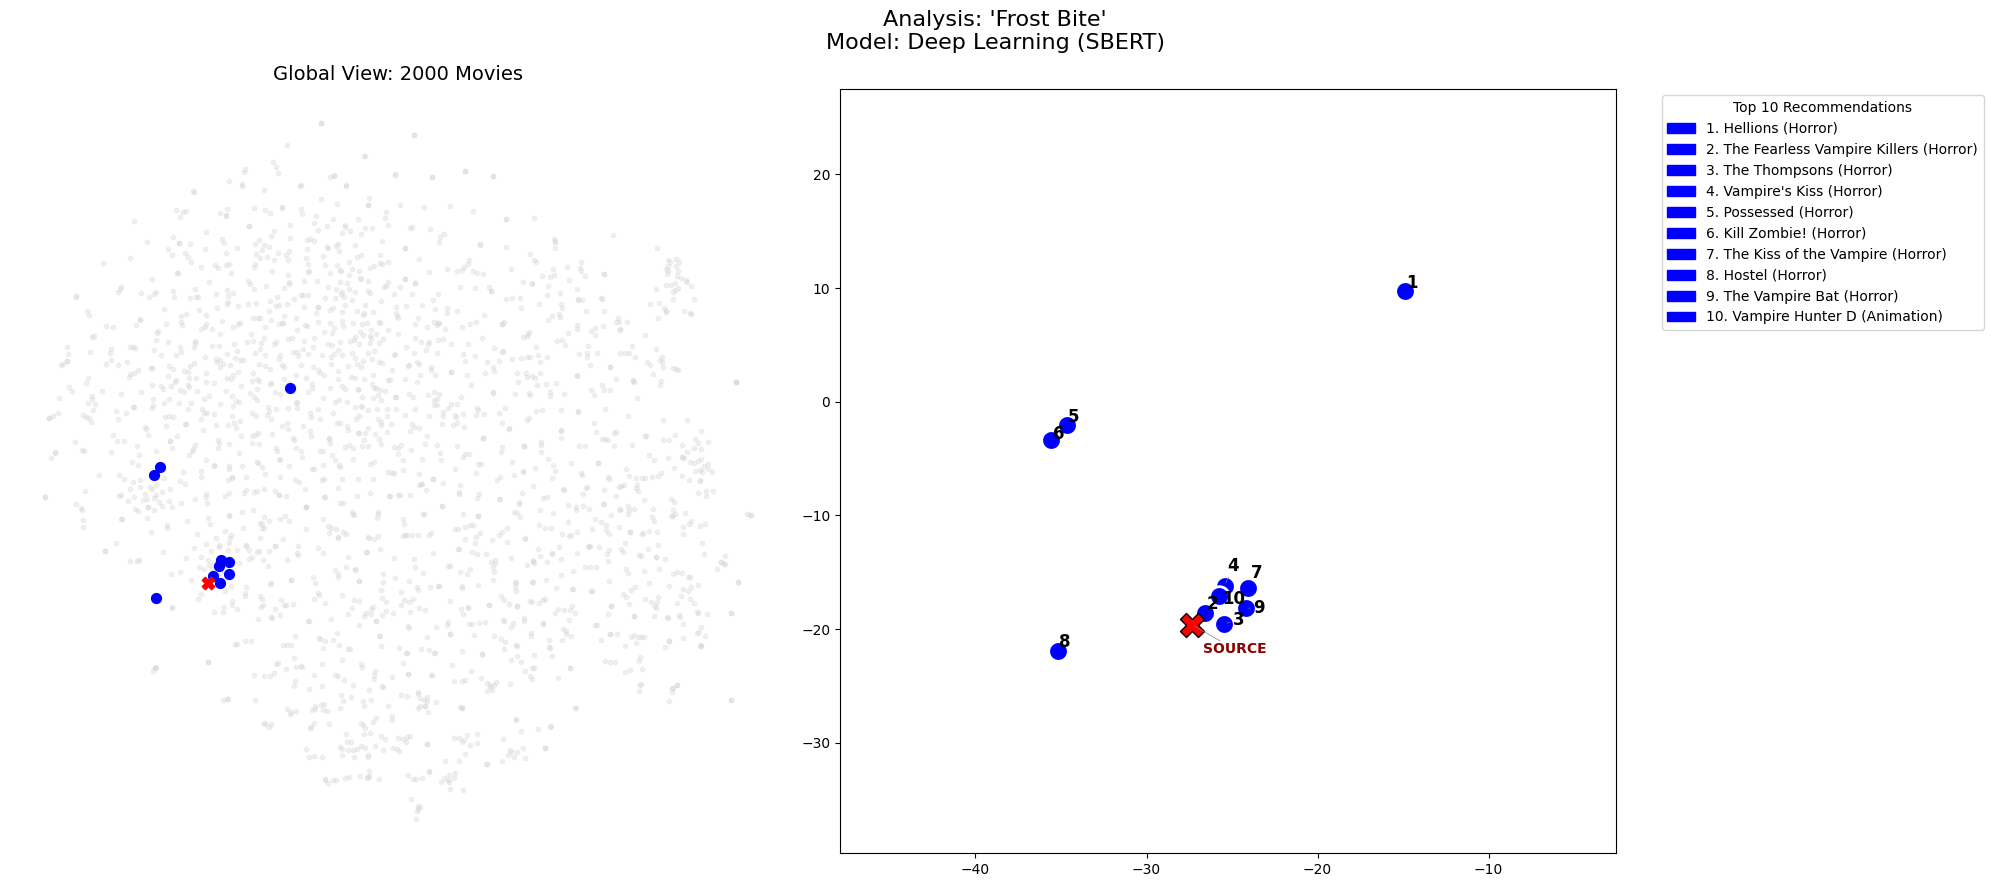

In [12]:
# Download a pre-trained model optimized for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

# Semantic vectorization - transform text into context-aware vectors
X_embeddings = model.encode(df_viz['full_text'].tolist(), show_progress_bar=False)

# Calculate the distance between semantic vectors
cosine_sim_sbert = cosine_similarity(X_embeddings, X_embeddings);

# Create semantic map based on model understanding
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_embedded_sbert = tsne.fit_transform(X_embeddings);

# Save the new coordinates
df_viz['x_sbert'] = X_embedded_sbert[:, 0]
df_viz['y_sbert'] = X_embedded_sbert[:, 1]

score_sbert = evaluate_precision_at_k(df_viz, cosine_sim_sbert)
print(f"Average Accuracy (SBERT): {score_sbert:.2%}")

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_sbert,
    x_col='x_sbert',
    y_col='y_sbert',
    model_name="Deep Learning (SBERT)"
)

##2. SBERT with MPNet

Average Accuracy (SBERT MPNet + Smart Text): 89.20%


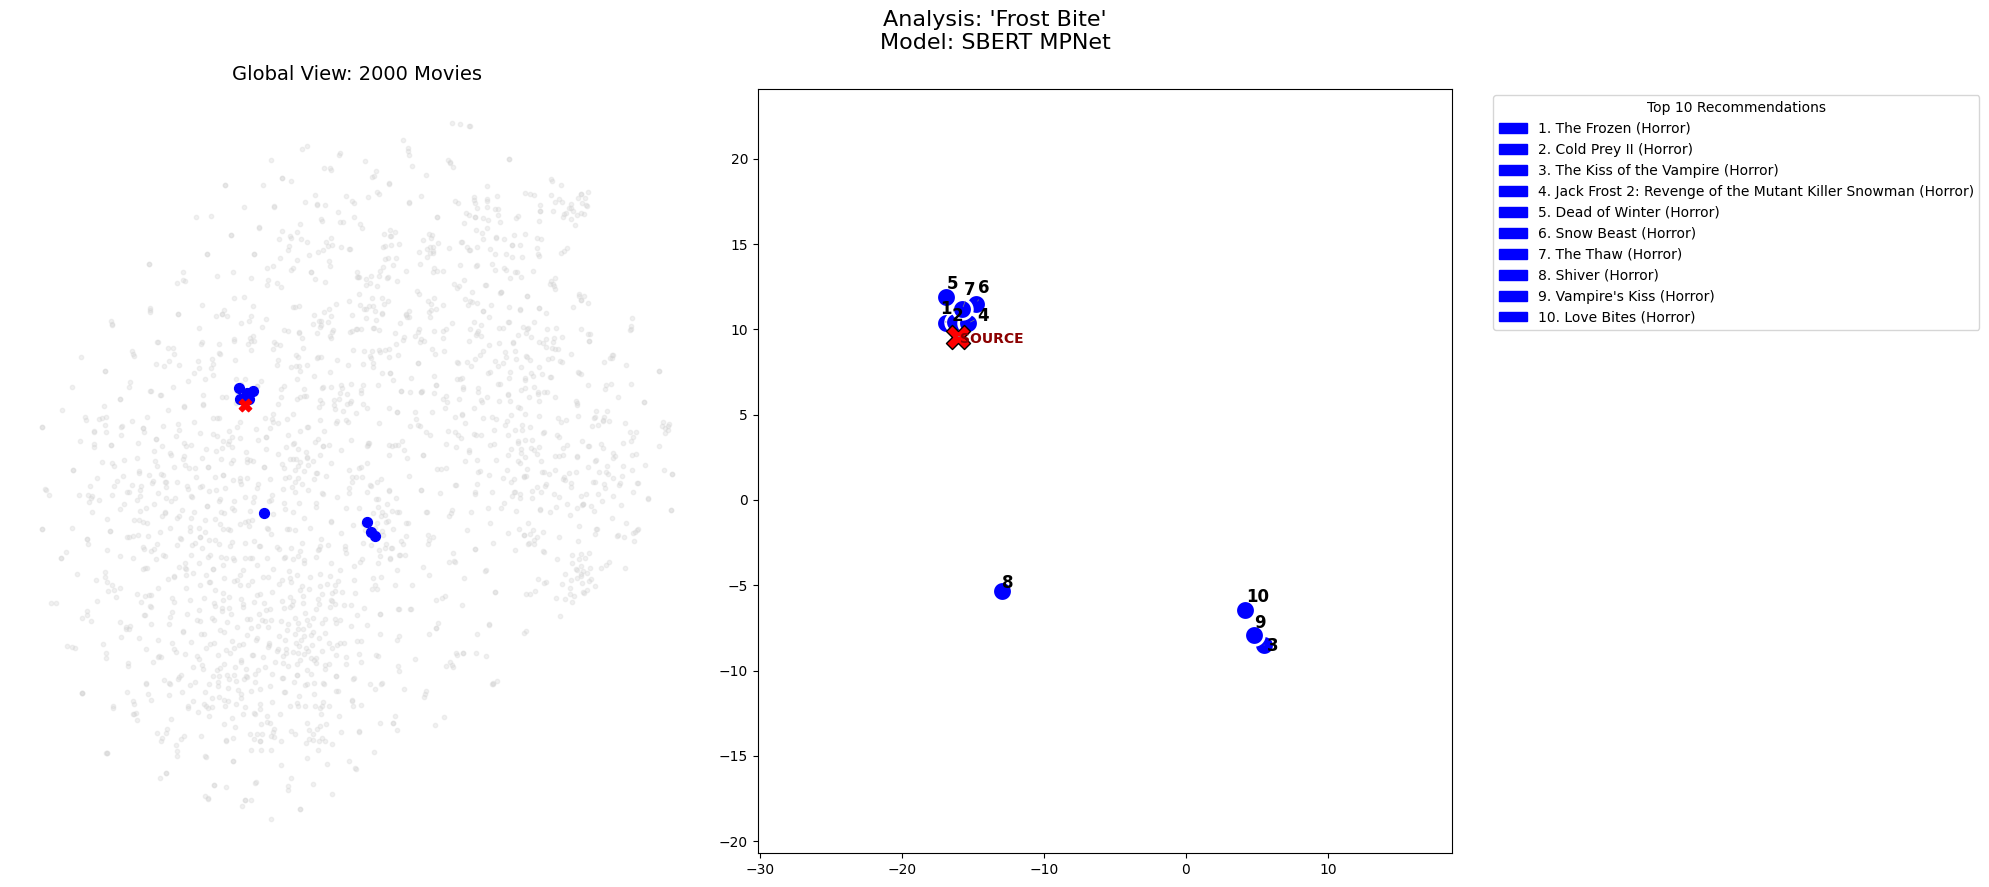

In [13]:
df_viz['genres_str'] = df_viz['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Build an optimized text for SBERT (text with sentences)
df_viz['sbert_text'] = (
    "Movie: " + df_viz['title'] + ". " +
    "Genres: " + df_viz['genres_str'] + ". " +
    "Keywords: " + df_viz['keywords_str'] + ". " +
    "About: " + df_viz['overview']
)

# Load MPNet Model
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

# Generate Embeddings
X_embeddings_mpnet = model_mpnet.encode(df_viz['sbert_text'].tolist(), show_progress_bar=False)

cosine_sim_mpnet = cosine_similarity(X_embeddings_mpnet, X_embeddings_mpnet);

# Optimized t-SNE for Clusters
# Increase 'learning_rate' and adjust 'perplexity' to force visual grouping
tsne = TSNE(n_components=2, perplexity=40, random_state=42, init='pca', learning_rate=200)
X_embedded_mpnet = tsne.fit_transform(X_embeddings_mpnet);

df_viz['x_mpnet'] = X_embedded_mpnet[:, 0]
df_viz['y_mpnet'] = X_embedded_mpnet[:, 1]

score_mpnet = evaluate_precision_at_k(df_viz, cosine_sim_mpnet)
print(f"Average Accuracy (SBERT MPNet + Smart Text): {score_mpnet:.2%}")

analyze_movie_similarity_dual(
    movie_title="Frost Bite",
    df=df_viz,
    sim_matrix=cosine_sim_mpnet,
    x_col='x_mpnet',
    y_col='y_mpnet',
    model_name="SBERT MPNet"
)

##3. SBERT with Cross-Encoder

In [18]:
def get_reranked_indices(movie_title, df, sim_matrix, ce_model):
    """
    Retrieve the top 10 most relevant movie recommendations for a given title using Cross‑encoder reranking for improved precision.

    Parameters:
      - movie_title: The title of the movie for which recommendations are requested.
      - df: Dataset containing movie metadata.
      - sim_matrix: Precomputed similarity matrix from a bi‑encoder model.
      - ce_model: Object with a `.predict()` method that takes pairs of texts and returns relevance scores.

    Returns:
      - A list of the top 10 recommended movie indices after reranking.
    """
    # Find the movie in the dataset
    matches = df[df['title'].str.lower() == movie_title.lower()]
    if matches.empty:
        return None

    query_idx = matches.index[0]

    # Retrieve similarity scores from the bi‑encoder
    sim_scores = list(enumerate(sim_matrix[df.index.get_loc(query_idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Take the top 50 most similar candidates
    candidate_indices = [x[0] for x in sim_scores[1:51]]

    # Prepare text pairs for the cross‑encoder
    query_text = df.loc[query_idx, 'sbert_text']
    model_inputs = [
        [query_text, df.loc[idx, 'sbert_text']]
        for idx in candidate_indices
    ]

    # Cross‑encoder scoring
    cross_scores = ce_model.predict(model_inputs)

    # Sort candidates by cross‑encoder scores
    reranked = sorted(
        list(zip(candidate_indices, cross_scores)),
        key=lambda x: x[1],
        reverse=True
    )

    # Return the top 10 reranked indices
    return [x[0] for x in reranked[:10]]

Processed: 0/50
Processed: 10/50
Processed: 20/50
Processed: 30/50
Processed: 40/50

Average Accuracy (Cross-Encoder Re-Ranking): 95.80%


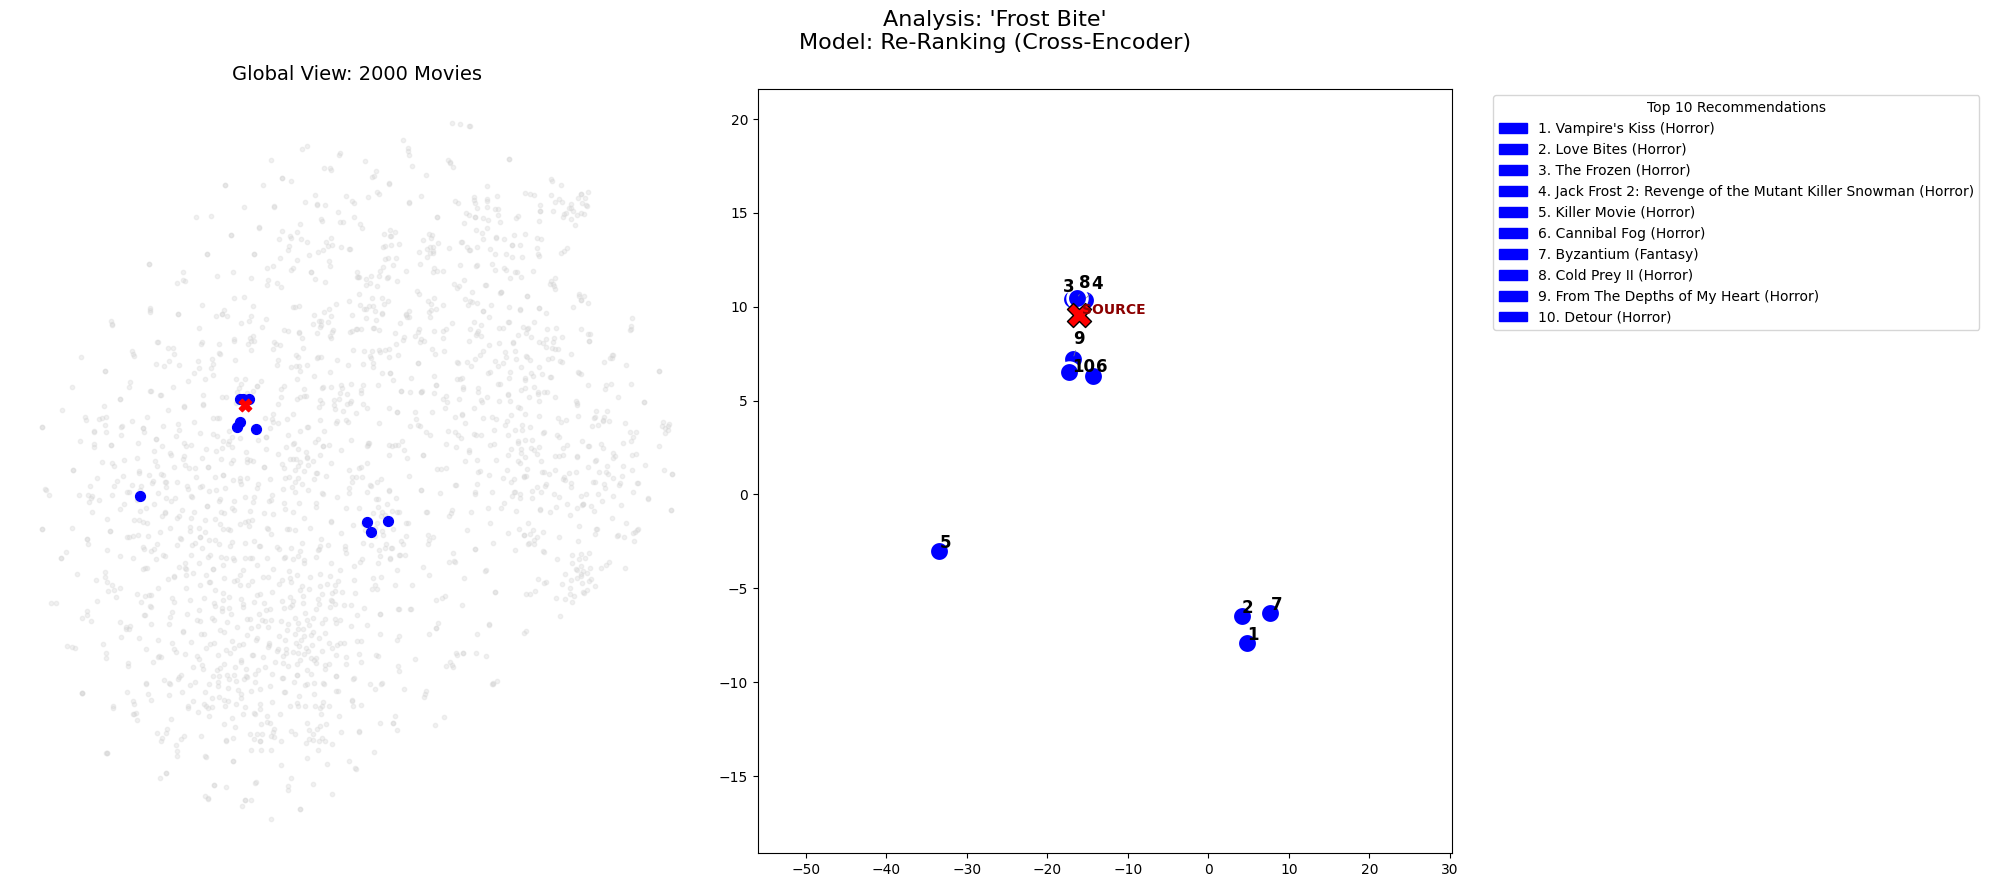

In [19]:


hf_logging.set_verbosity_error()
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)



cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Calculate the global score
global_acc_rerank = evaluate_precision_at_k(df=df_viz, sim_matrix=cosine_sim_mpnet, ce_model=cross_encoder, n_samples=50)

print(f"\nAverage Accuracy (Cross-Encoder Re-Ranking): {global_acc_rerank:.2%}")

if 'x_mpnet' not in df_viz.columns:
    pass

best_indices = get_reranked_indices("Frost Bite", df_viz, cosine_sim_mpnet, cross_encoder)

analyze_movie_similarity_dual(movie_title="Frost Bite",df=df_viz,sim_matrix=None,x_col='x_mpnet',y_col='y_mpnet',model_name="Re-Ranking (Cross-Encoder)",custom_indices=best_indices)

#Hybrid

##1. Hybrid System (MPNet + LSA)

Average Accuracy (Hybrid System: MPNet + LSA): 87.40%


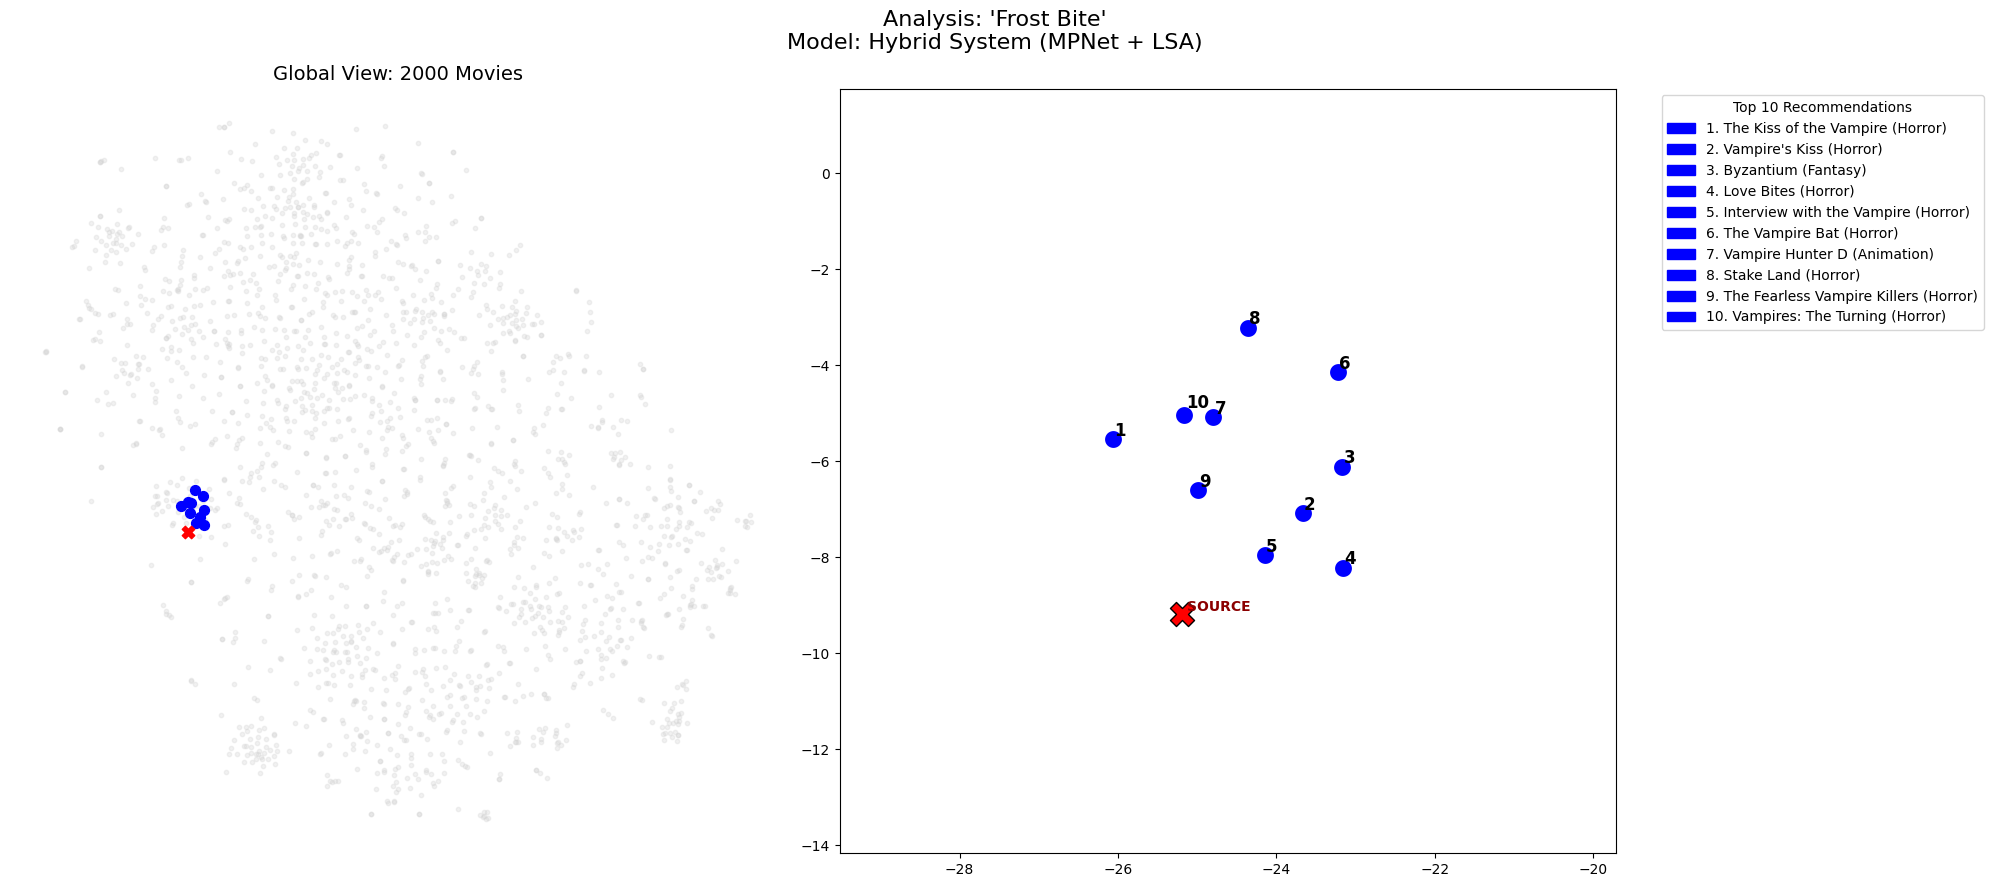

In [21]:
alpha = 0.7
cosine_sim_hybrid = (alpha * cosine_sim_mpnet) + ((1 - alpha) * cosine_sim_best);

# Normalize vectors before concatenation to have similar scales
X_mpnet_norm = normalize(X_embeddings_mpnet)
X_lsa_norm = normalize(X_lsa_best)

# Concatenate SBERT vectors with LSA ones
# Weight 0.5 for visualization
X_hybrid_concat = np.hstack([X_mpnet_norm, X_lsa_norm * 0.5]);

# t-SNE on the new combined space
tsne = TSNE(n_components=2, perplexity=40, random_state=42, init='pca', learning_rate=200)
X_embedded_hybrid = tsne.fit_transform(X_hybrid_concat);

df_viz['x_hybrid'] = X_embedded_hybrid[:, 0]
df_viz['y_hybrid'] = X_embedded_hybrid[:, 1]

score_hybrid = evaluate_precision_at_k(df_viz, cosine_sim_hybrid)
print(f"Average Accuracy (Hybrid System: MPNet + LSA): {score_hybrid:.2%}")

analyze_movie_similarity_dual(movie_title="Frost Bite", df=df_viz, sim_matrix=cosine_sim_hybrid,x_col='x_hybrid', y_col='y_hybrid', model_name="Hybrid System (MPNet + LSA)")

##2. Hybrid Tuned

-> Alpha 0.00 (MPNet) + 1.00 (LSA) = Accuracy 83.00%
-> Alpha 0.20 (MPNet) + 0.80 (LSA) = Accuracy 85.20%
-> Alpha 0.40 (MPNet) + 0.60 (LSA) = Accuracy 80.80%
-> Alpha 0.60 (MPNet) + 0.40 (LSA) = Accuracy 86.20%
-> Alpha 0.80 (MPNet) + 0.20 (LSA) = Accuracy 89.40%
-> Alpha 0.90 (MPNet) + 0.10 (LSA) = Accuracy 87.60%
-> Alpha 0.95 (MPNet) + 0.05 (LSA) = Accuracy 90.40%
-> Alpha 1.00 (MPNet) + 0.00 (LSA) = Accuracy 92.00%

BEST CONFIGURATION: Alpha = 1.0 -> Accuracy: 92.00%



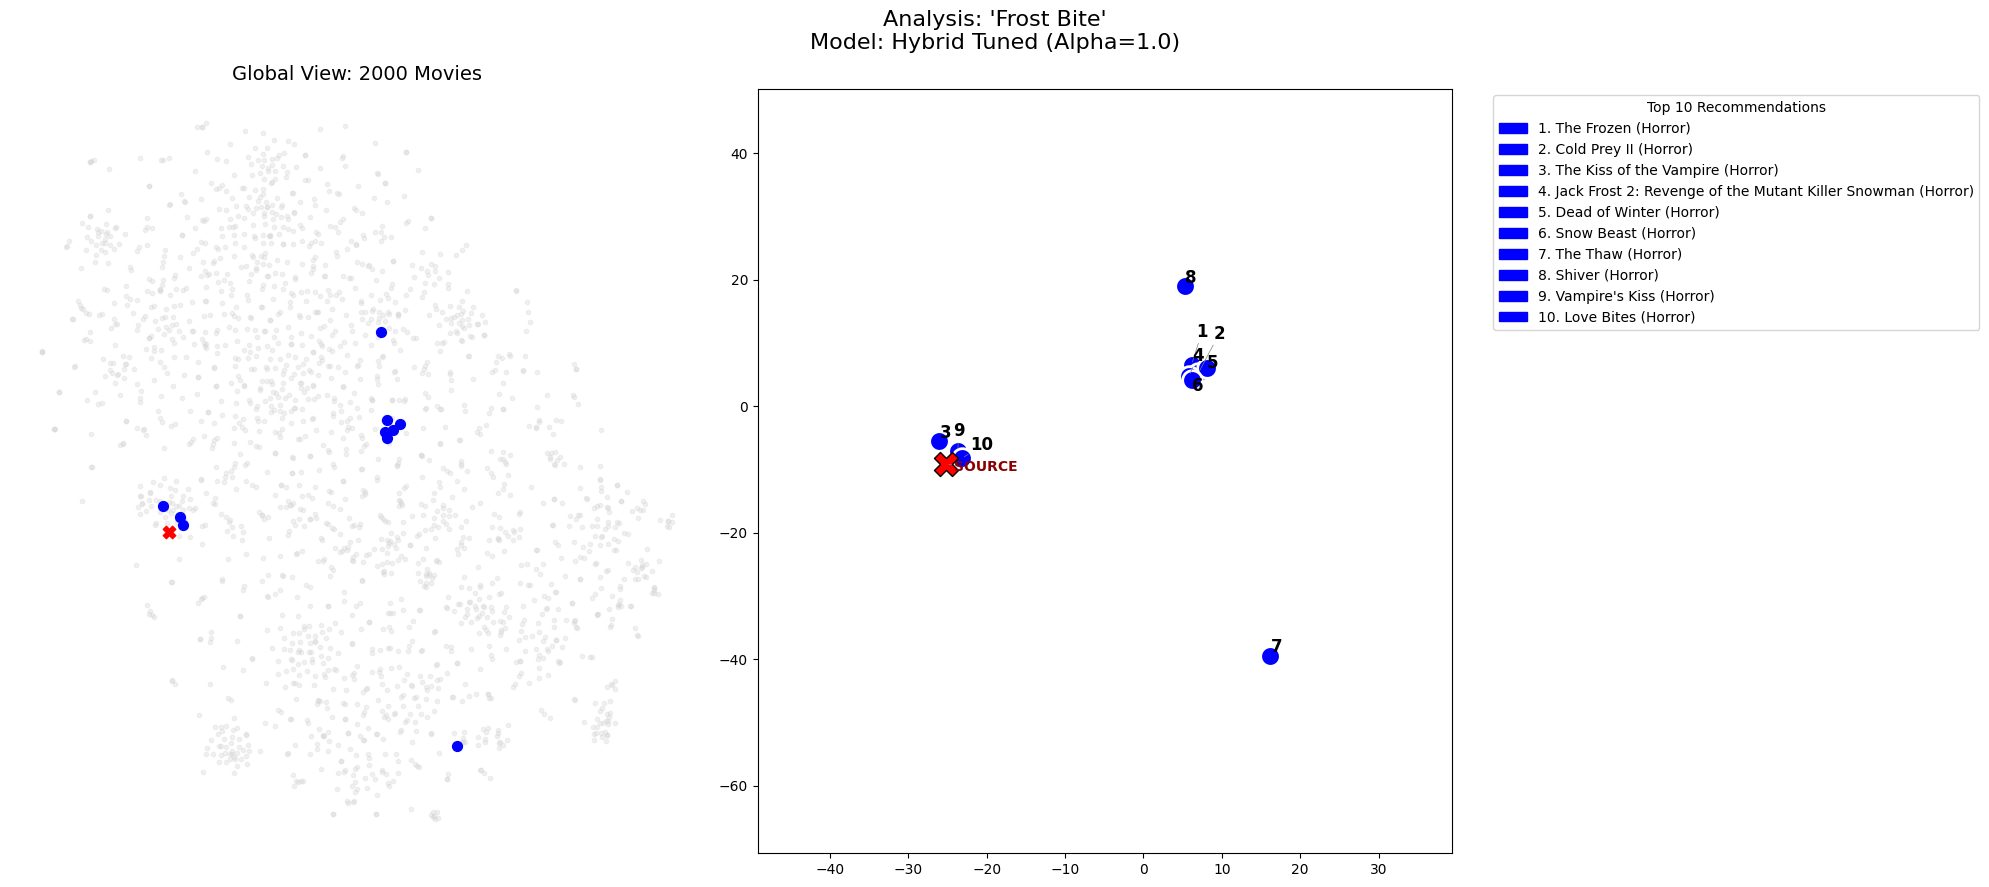

In [22]:
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
best_score = 0
best_alpha = 0

for alpha in alphas:
    # Combinăm matricile cu ponderea curentă
    # Hybrid = (alpha * DeepLearning) + ((1-alpha) * Statistic)
    sim_hybrid_test = (alpha * cosine_sim_mpnet) + ((1 - alpha) * cosine_sim_best);

    # Evaluăm
    score = evaluate_precision_at_k(df_viz, sim_hybrid_test)

    print(f"-> Alpha {alpha:.2f} (MPNet) + {1-alpha:.2f} (LSA) = Accuracy {score:.2%}")

    if score > best_score:
        best_score = score
        best_alpha = alpha

print(f"\nBEST CONFIGURATION: Alpha = {best_alpha} -> Accuracy: {best_score:.2%}")
print()
final_hybrid_sim = (best_alpha * cosine_sim_mpnet) + ((1 - best_alpha) * cosine_sim_best);

analyze_movie_similarity_dual(movie_title="Frost Bite", df=df_viz, sim_matrix=final_hybrid_sim, x_col='x_hybrid',y_col='y_hybrid', model_name=f"Hybrid Tuned (Alpha={best_alpha})")